In [1]:
from PIL import Image
import numpy as np
import open3d as o3d
from pdb import set_trace as bp
import random

In [2]:
info_file = '/media/ivenwu/My_Disk/video_obj_sample/african_elephant_female/info/0001.npz'
image_path = '/media/ivenwu/My_Disk/video_obj_sample/african_elephant_female/0001.png'

In [3]:
info = np.load(info_file)
image = Image.open(image_path)

In [4]:
intrin = info['intrinsic_mat']
extrin = info['extrinsic_mat']

In [5]:
intrin = np.eye(4)
intrin[:-1,:-1] = info['intrinsic_mat']
extrin = np.concatenate([extrin,np.array([0,0,0,1]).reshape(1,-1)],axis=0)
recover_mat = np.linalg.pinv(intrin.dot(extrin))

现在需要的是，把depth对应，因为从projection得到的depth和数据里面的depth不是一个东西(其实是一个东西）

In [6]:
depth = info['depth_map']
seg = info['segmentation_masks']


In [7]:
x,y = np.where(seg!=0)
co = np.concatenate([x.reshape(1,-1),y.reshape(1,-1)]).T
# random.sample(range(co.shape[0]),3)
select_co = co
z = [depth[c[0],c[1]] for c in select_co]
z = np.array(z).reshape(-1,1)

xyz = np.concatenate([select_co,z],axis=1)
xyz.shape

(84277, 3)

In [8]:
xyzw = np.concatenate([xyz,np.ones((xyz.shape[0],1))],axis=1)
recon = recover_mat.dot(xyzw.T).T
recon = recon[:,:-1]
recon.shape

(84277, 3)

In [14]:
recon[:,-1] = 0

In [36]:
# xyz[:,:-1] = xyz[:,:-1]/xyz[:,[2]]
xyz[:,:-1] = (xyz[:,:-1]-512)/512
xyz[:,-1] = (xyz[:,-1]-xyz[:,-1].min())/(xyz[:,-1].max()-xyz[:,-1].min())

In [15]:
vis = o3d.visualization.Visualizer()
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(recon)

o3d.visualization.draw_geometries([pcd])

In [25]:
def recover_depth(image,info):
    INVALID_POINT = -1
    if type(image) !=np.ndarray:
        image = np.array(image)
    depth_ori = info['depth_map']
    intrin = info['intrinsic_mat']
    
    depth_new = np.zeros(depth_ori.shape)
    fx,fy,cx,cy = intrin[0,0],intrin[1,1],intrin[0,-1],intrin[1,-1]
    for x in range(image.shape[0]):
        a = (cx-x)/fx
        for y in range(image.shape[1]):
            b = (cy-y)/fy
            if depth_ori[x,y]!=INVALID_POINT:
                depth_new[x,y] = depth_ori[x,y] * np.linalg.norm([1,a,b])
    return depth_new        

In [26]:
depth_new = recover_depth(image,info)

In [28]:
depth_new

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [15.90887458, 15.90887553, 15.9088757 , ..., 15.90887271,
        15.90887255, 15.90887458],
       [15.89251302, 15.8925136 , 15.89251339, ..., 15.89251339,
        15.89251261, 15.89251302],
       [15.87618586, 15.87618807, 15.87618748, ..., 15.87618748,
        15.87618608, 15.87618686]])

In [58]:
dep = info['depth_map']
dep[np.where(info['segmentation_masks']==0)]=255
dep[dep!=255].min()

23.806984

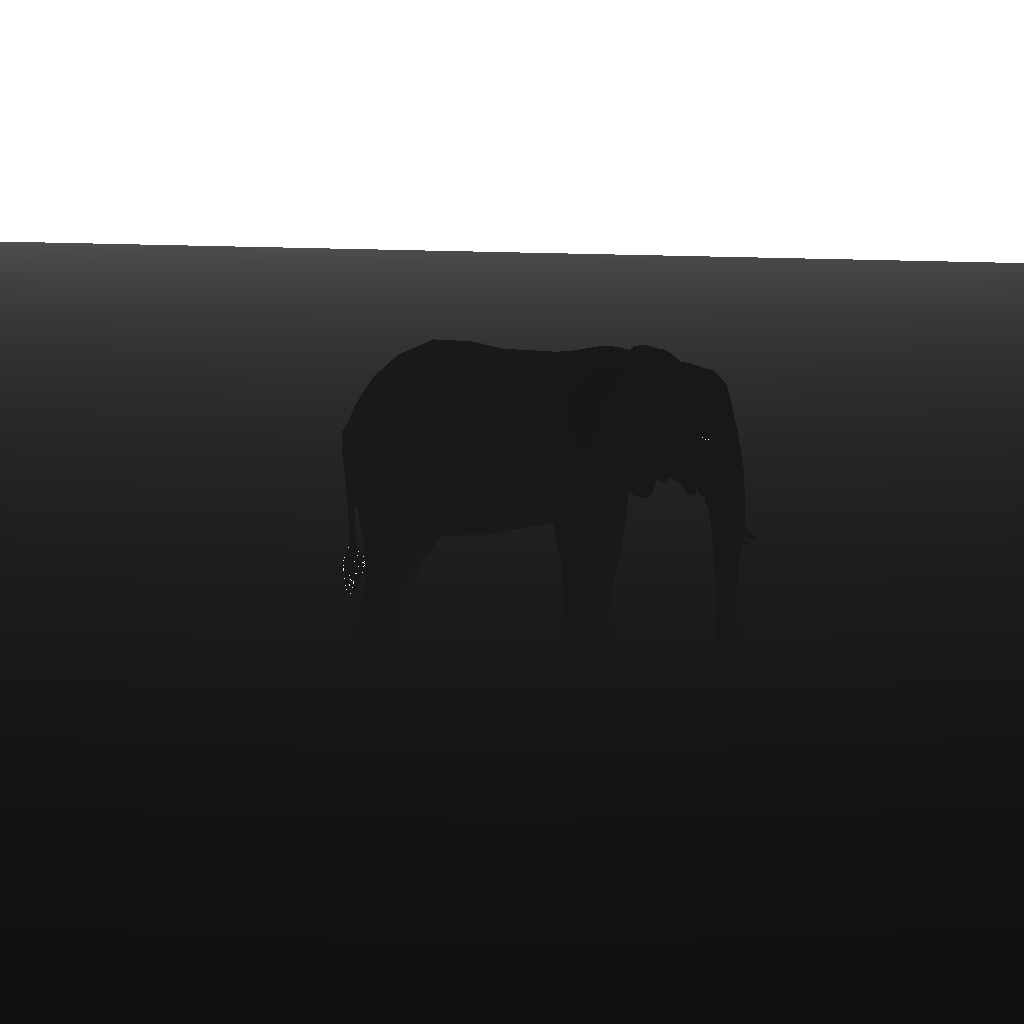

In [34]:
depth_ori = info['depth_map'].astype(np.uint8)
depth = Image.fromarray(depth_ori)
depth

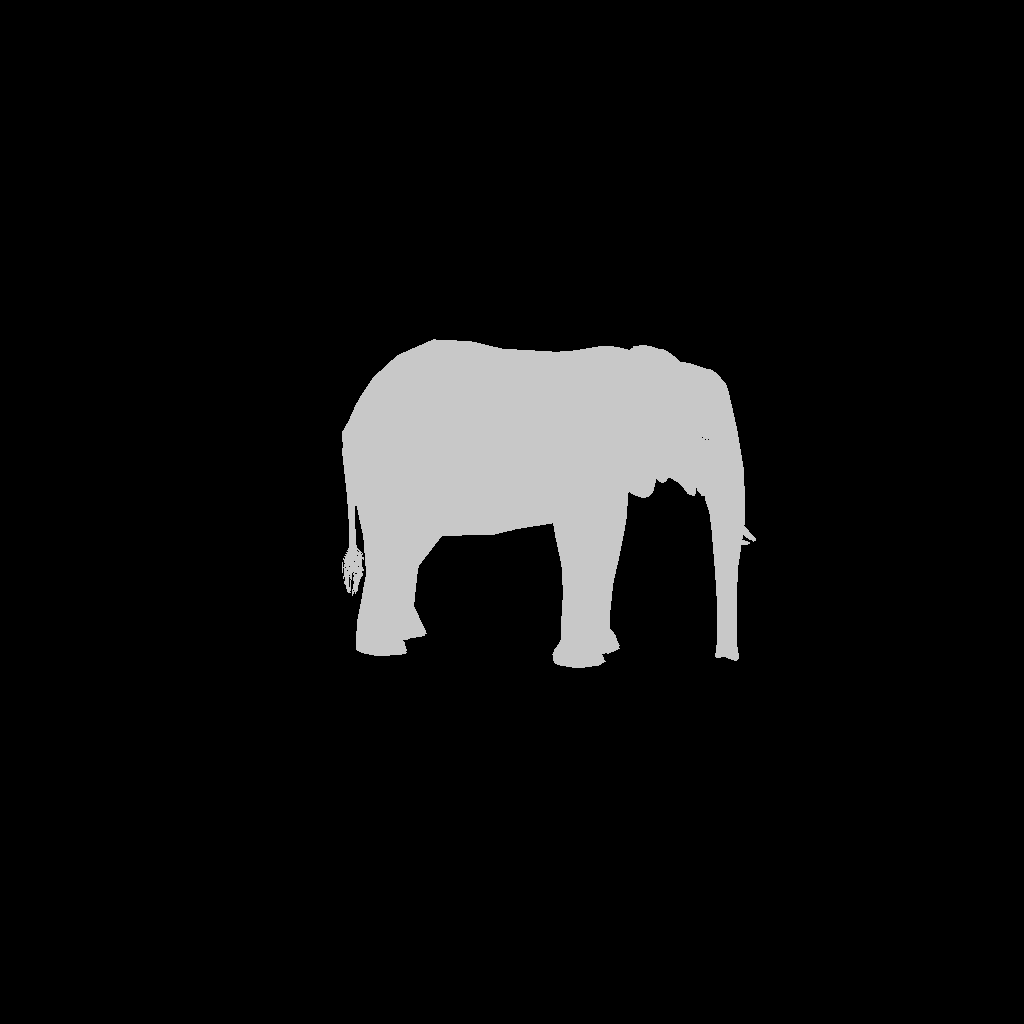

In [52]:
seg = info['segmentation_masks']
Image.fromarray(seg.astype(np.uint8))

In [ ]:
info